In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 2, 20

In [4]:
x = np.linspace(0,1,500)
x_test=np.linspace(1,2,500)

In [5]:
x = np.array([x for _ in range(100)])
x_test= np.array([x_test for _ in range(100)])


(100, 500) (100, 500)


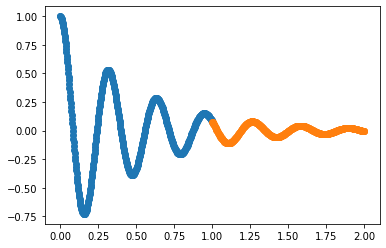

In [6]:

N = 100 # number of samples
y = oscillator(d, w0, x).astype(np.float32)
y_test =oscillator(d, w0, x_test).astype(np.float32)
print(x.shape,y.shape)
plt.scatter(x[1],y[1])
plt.scatter(x_test[1],y_test[1])

In [7]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [8]:
x = torch.linspace(0,1,500).requires_grad_()
x = x.repeat(100,1)
y = oscillator(d, w0, x)

In [9]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers).to(device)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers).to(device)
        self.linear = nn.Linear(self.hidden_layers, outputs).to(device)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=1.0)
        self.optimizer_Adam = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2)# output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1).to(device)
        return outputs
    


2 min 

In [10]:
class PhysicsInformedNN():
    
    def __init__(self):
        # deep neural networks
        self.dnn = LSTM().to(device)
        
        
    def net_u(self,t,future_preds=0):  
        u = self.dnn.forward(t, future_preds)
        return u
    
    def derivates(self, u ,coordinates):
        
        coordinates = (coordinates.to(device),)
        u_t = torch.gradient(u, spacing = coordinates)[0].to(device) 
        u_tt = torch.gradient(u, spacing = coordinates)[0].to(device) 

        return u_t , u_tt
    
    def net_f(self,t,lambda1=4.0,lambda2=400.0):
        """ The pytorch autograd version of calculating residual """

        u = self.net_u(t)
        
        u_t = torch.zeros(len(u),len(u[0])).to(device)
        u_tt = torch.zeros(len(u),len(u[0])).to(device)
        
        coordinate_t = torch.linspace(0,1,len(u[0]))
        for i , time_serie in enumerate(u): 
            u_t[i], u_tt[i] =  self.derivates(time_serie, coordinate_t)
            
        f = u_tt + lambda1*u_t + lambda2*u
        return f.to(device), u , u_t , u_tt
    
    def predict(self, t,future_preds=0):
        self.dnn.eval()
        u = self.net_u(t,future_preds=0)
        return u 

In [11]:
model = PhysicsInformedNN()


(1e-9) y (1e-8) physics[,1:]
ok

STEP:  0
loss: 1.345635175704956
loss: 1.0575895309448242
loss: 0.6340269446372986
loss: 0.5950644016265869
loss: 0.12270833551883698
loss: 1.7560715675354004
loss: 0.18158312141895294
loss: 0.35545623302459717
loss: 0.12435370683670044
loss: 0.10911521315574646
loss: 0.10360928624868393
loss: 0.10202420502901077
loss: 0.09314430505037308
loss: 0.08307035267353058
loss: 0.0652262419462204
loss: 0.04483027383685112
loss: 0.014911807142198086
loss: 0.005392400547862053
loss: 0.004546132404357195
loss: 0.004321750719100237
Loss u: 4.306647e-03


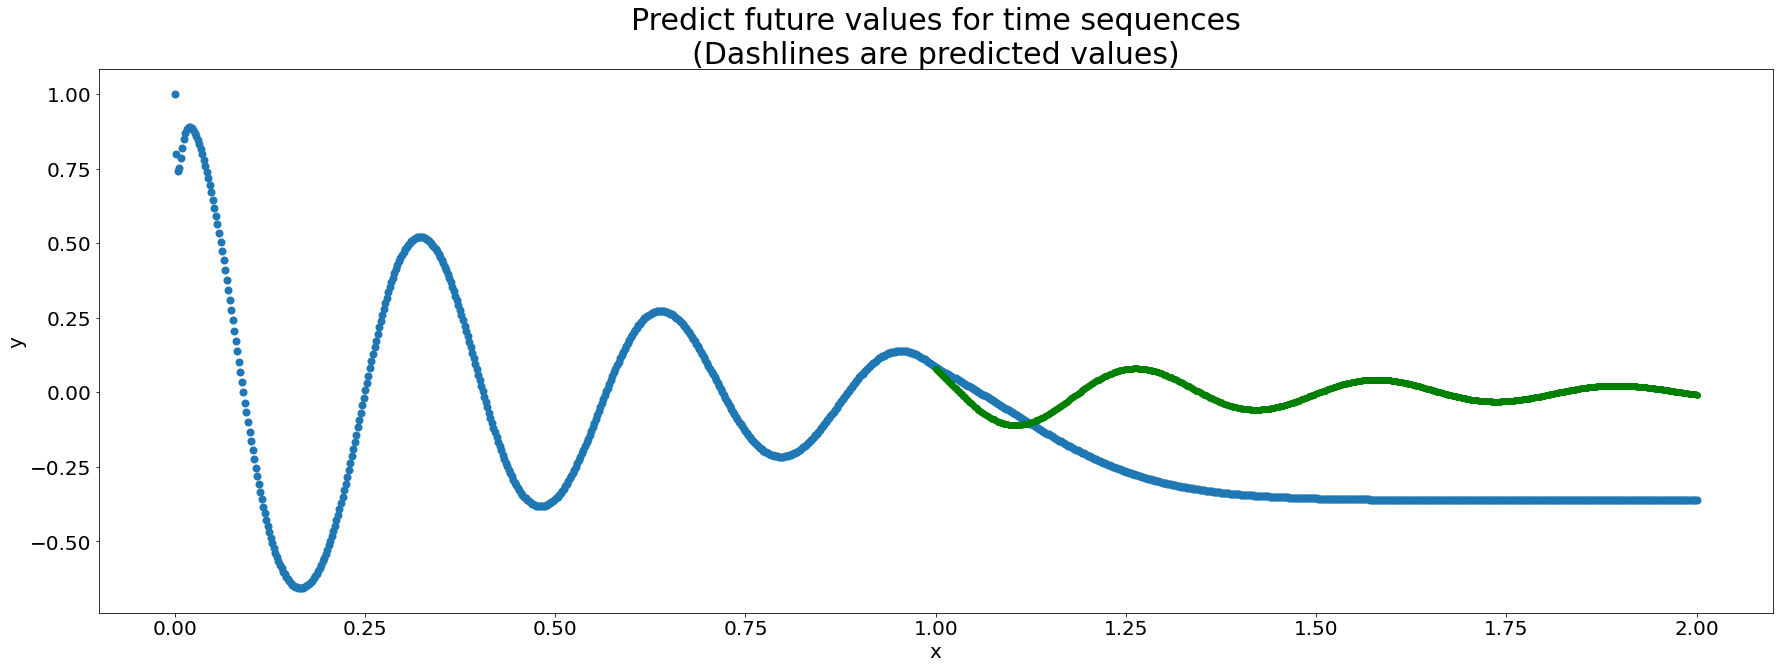

STEP:  1
loss: 0.004316382575780153
loss: 0.004297106061130762
loss: 0.004248371813446283
loss: 0.004124955274164677
loss: 0.003847315441817045
loss: 0.0032770971301943064
loss: 0.0022322386503219604
loss: 0.0016325695905834436
loss: 0.0012193031143397093
loss: 0.0010283656883984804
loss: 0.0008388023125007749
loss: 0.000667599611915648
loss: 0.0005334050511009991
loss: 0.00047200574772432446
loss: 0.00036632531555369496
loss: 0.0003143036738038063
loss: 0.00033000356052070856
loss: 0.00023863538808654994
loss: 0.00020895681518595666
loss: 0.0004096797783859074
Loss u: 1.634048e-04


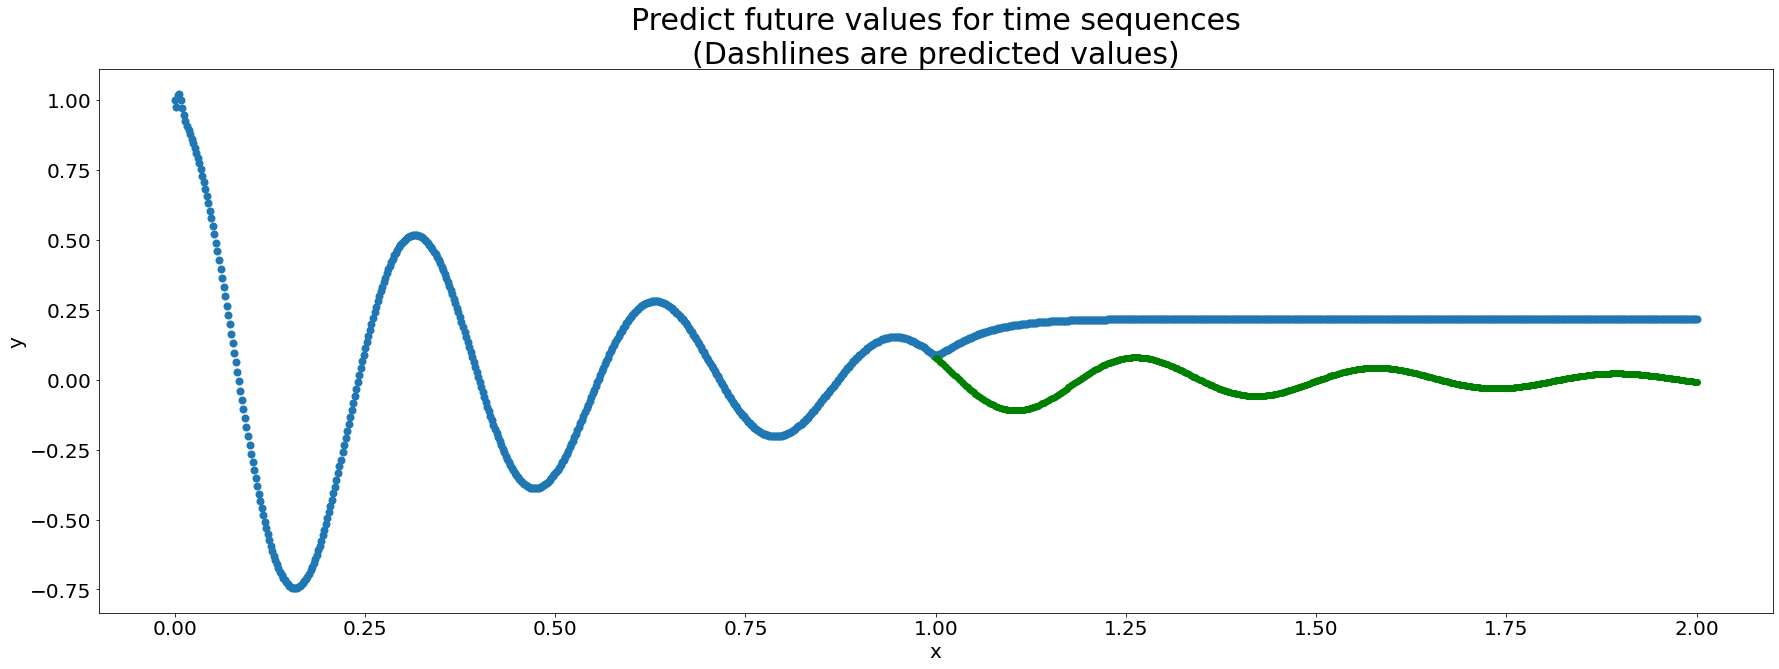

STEP:  2
loss: 0.00017346866661682725
loss: 0.00015360677207354456
loss: 0.0003525572537910193
loss: 0.00013282375584822148
loss: 0.00012019216228509322
loss: 0.00017860354273580015
loss: 0.0001040834904415533
loss: 9.642692020861432e-05
loss: 9.177545871352777e-05
loss: 8.402273670071736e-05
loss: 8.091882773442194e-05
loss: 7.44445133022964e-05
loss: 7.341110904235393e-05
loss: 7.269633351825178e-05
loss: 7.265828753588721e-05
loss: 7.225847366498783e-05
loss: 7.164851558627561e-05
loss: 6.985163781791925e-05
loss: 6.619100895477459e-05
loss: 5.824621257488616e-05
Loss u: 3.144637e-05


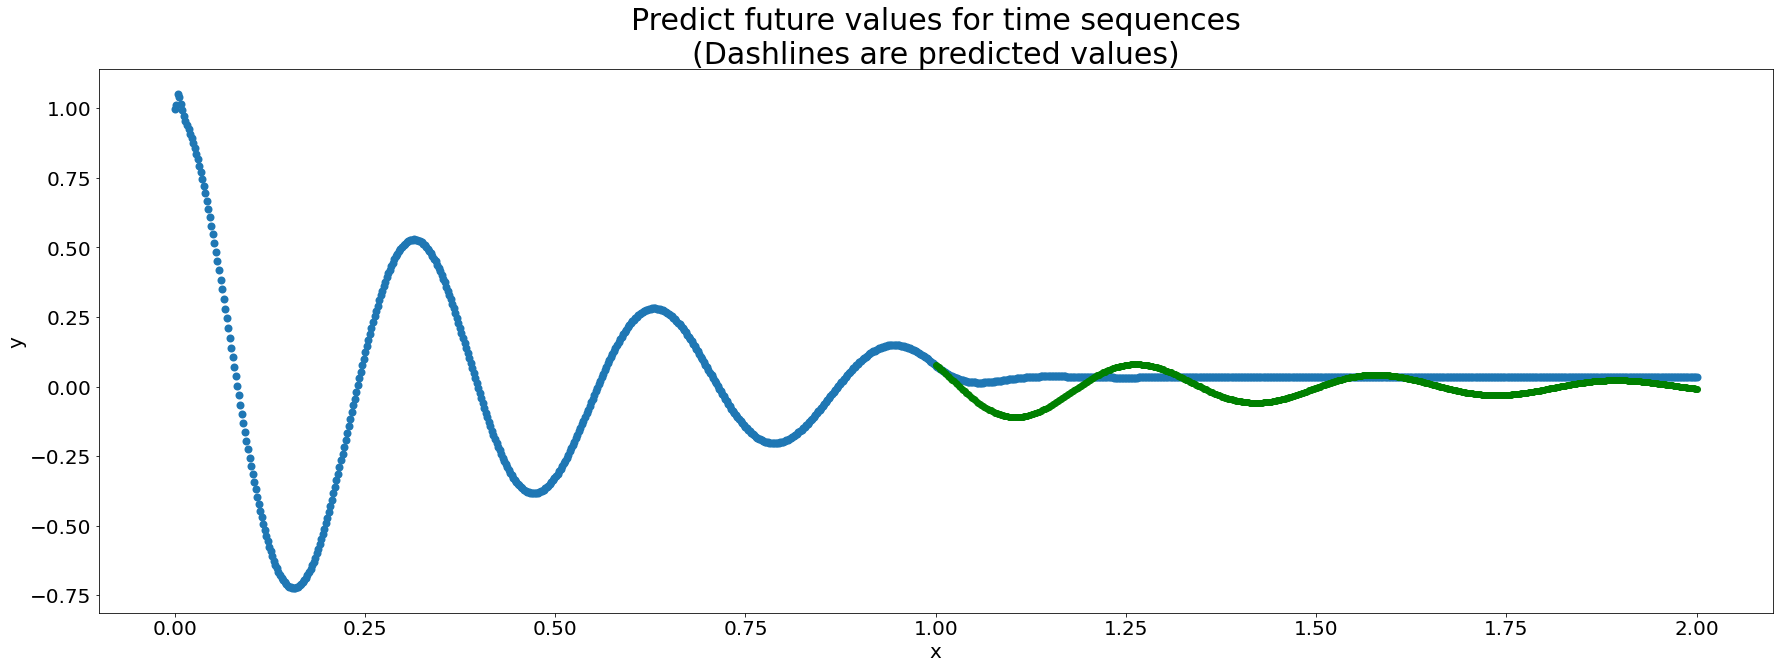

STEP:  3
loss: 4.4518554204842076e-05
loss: 3.5837001632899046e-05
loss: 3.132325946353376e-05
loss: 2.97357291856315e-05
loss: 2.827951539075002e-05
loss: 2.7444124498288147e-05
loss: 2.706811392272357e-05
loss: 2.6897096176980995e-05
loss: 2.6411802537040785e-05
loss: 2.5307184841949493e-05
loss: 2.387362292211037e-05
loss: 2.1323929104255512e-05
loss: 1.9392979083932005e-05
loss: 1.906769466586411e-05
loss: 1.7943735656444915e-05
loss: 1.595225876371842e-05
loss: 1.5612153219990432e-05
loss: 1.5547240764135495e-05
loss: 1.5542007531621493e-05
loss: 1.5534904378000647e-05
Loss u: 5.790311e-06


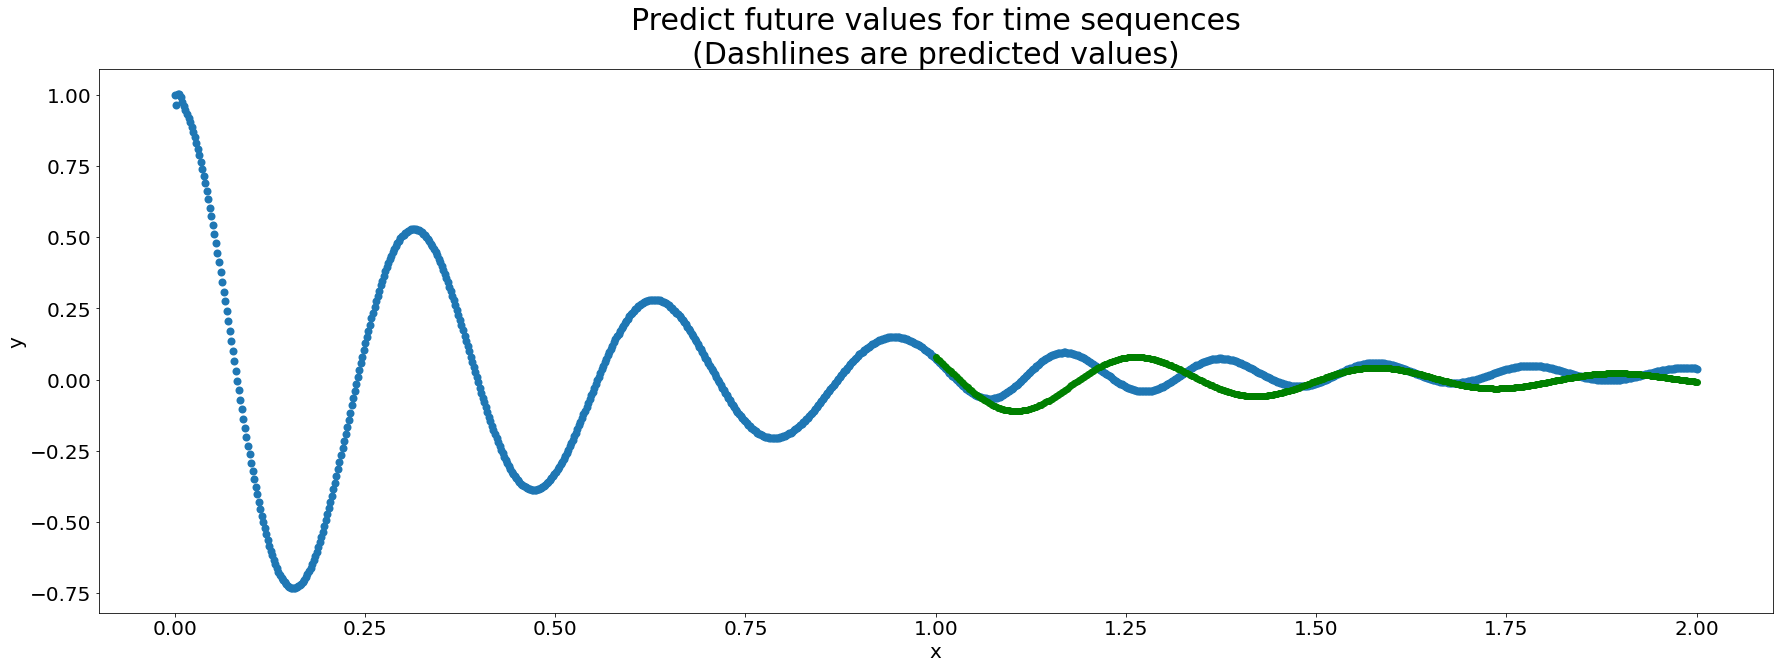

STEP:  4
loss: 1.5532563338638283e-05
loss: 1.5519139196840115e-05
loss: 1.542569589219056e-05
loss: 1.5279912986443378e-05
loss: 1.4913666745997034e-05
loss: 1.4408494280360173e-05
loss: 1.3960890100861434e-05
loss: 1.3587450666818768e-05
loss: 1.342223822575761e-05
loss: 1.3392263099376578e-05
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


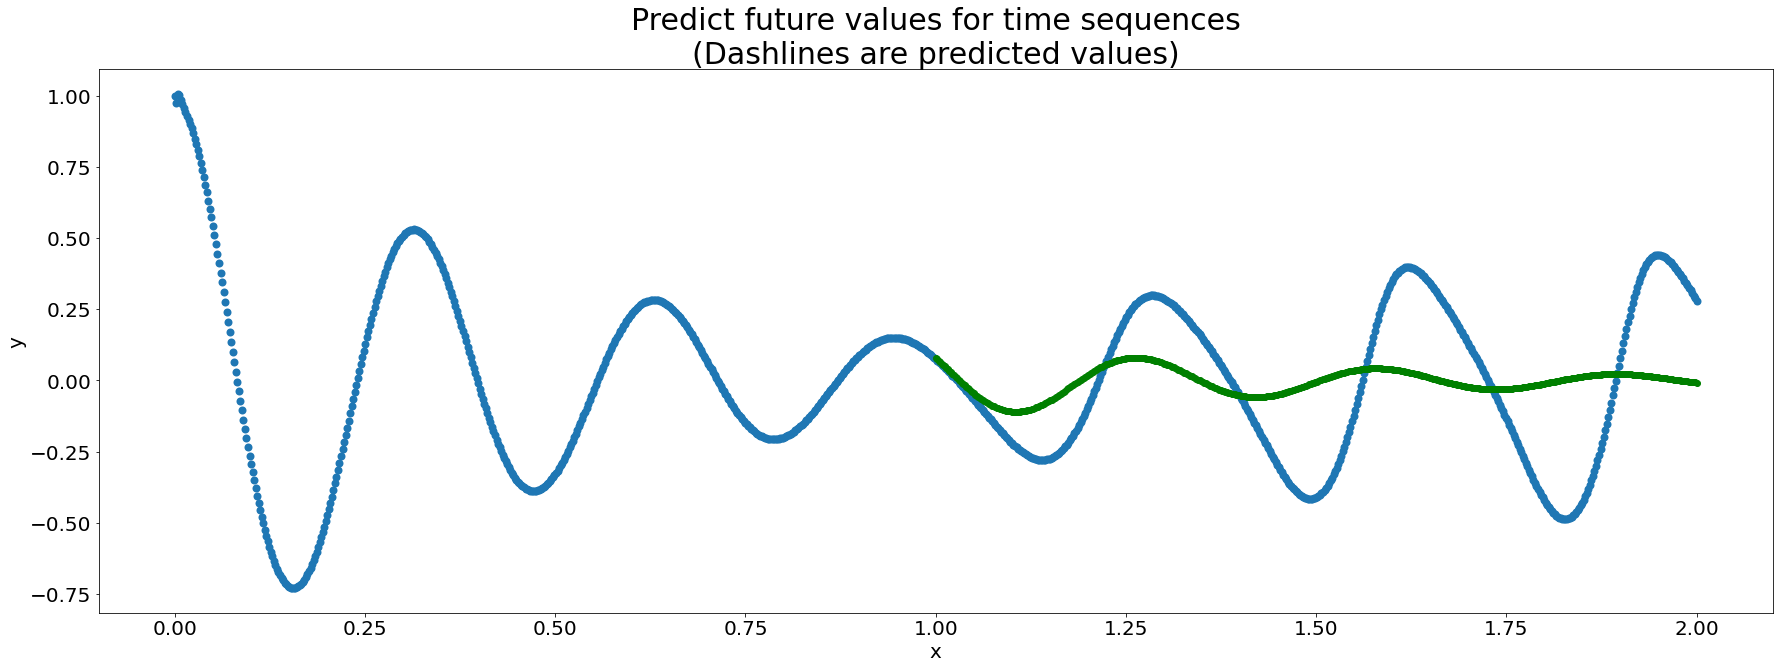

STEP:  5
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


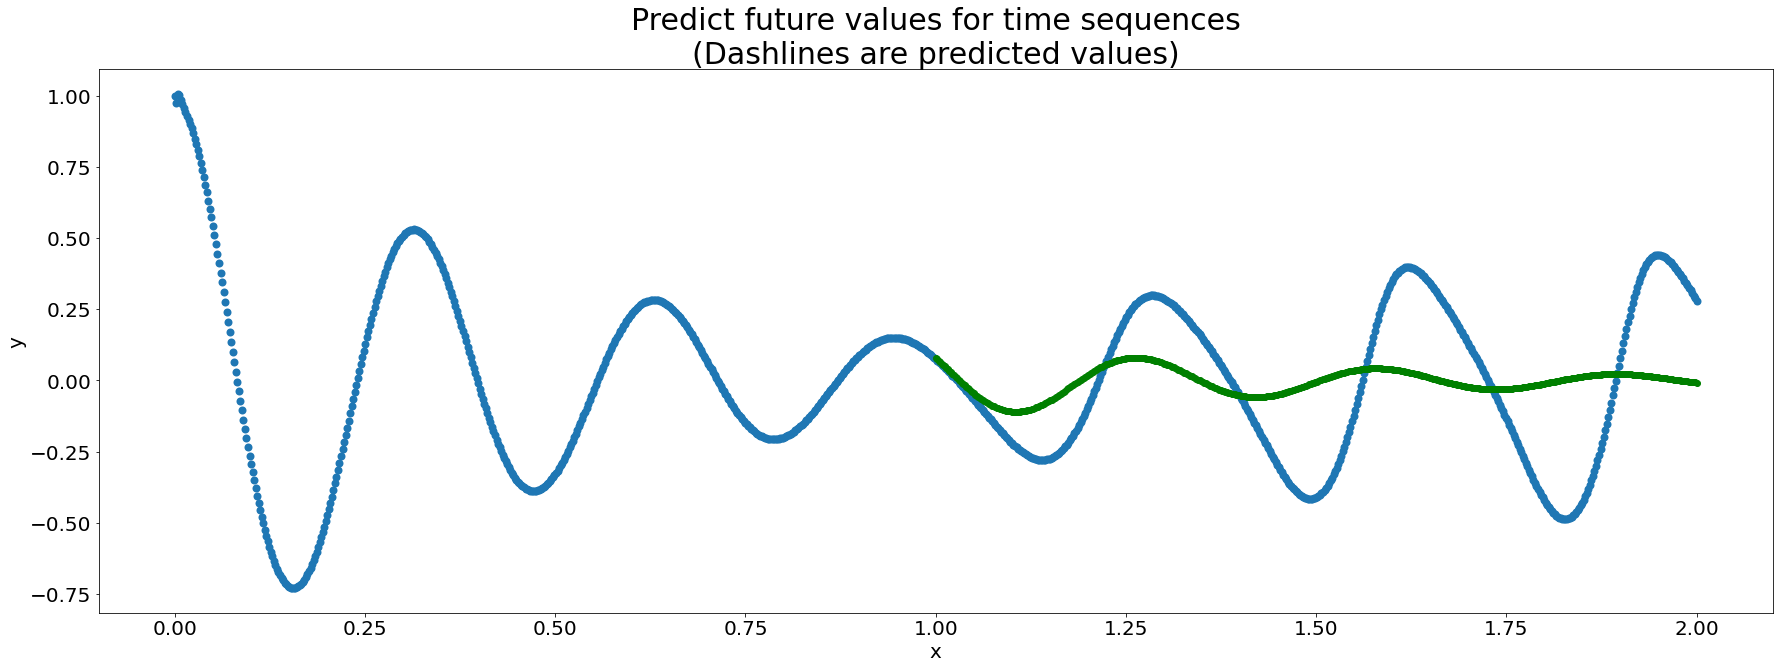

STEP:  6
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


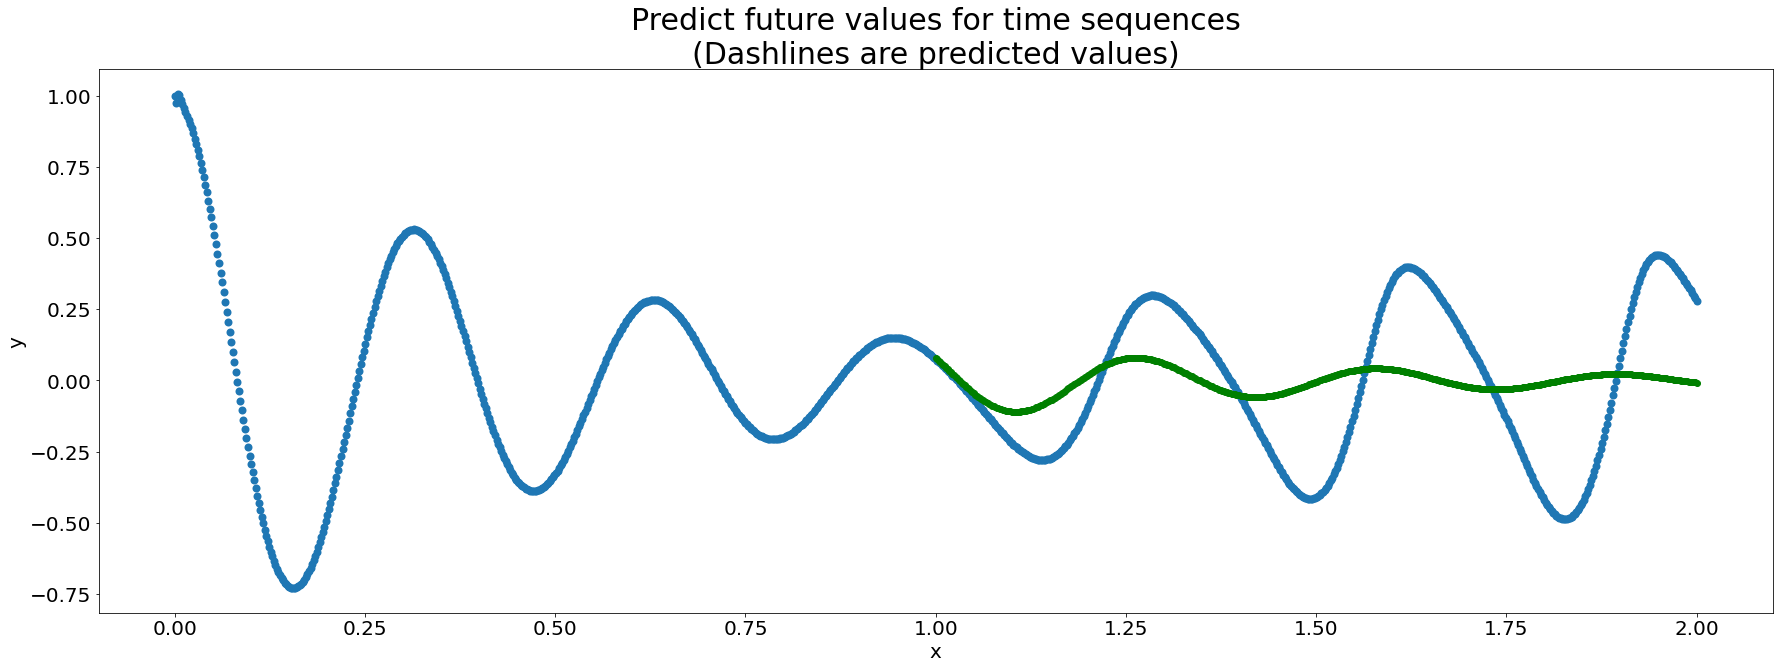

STEP:  7
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


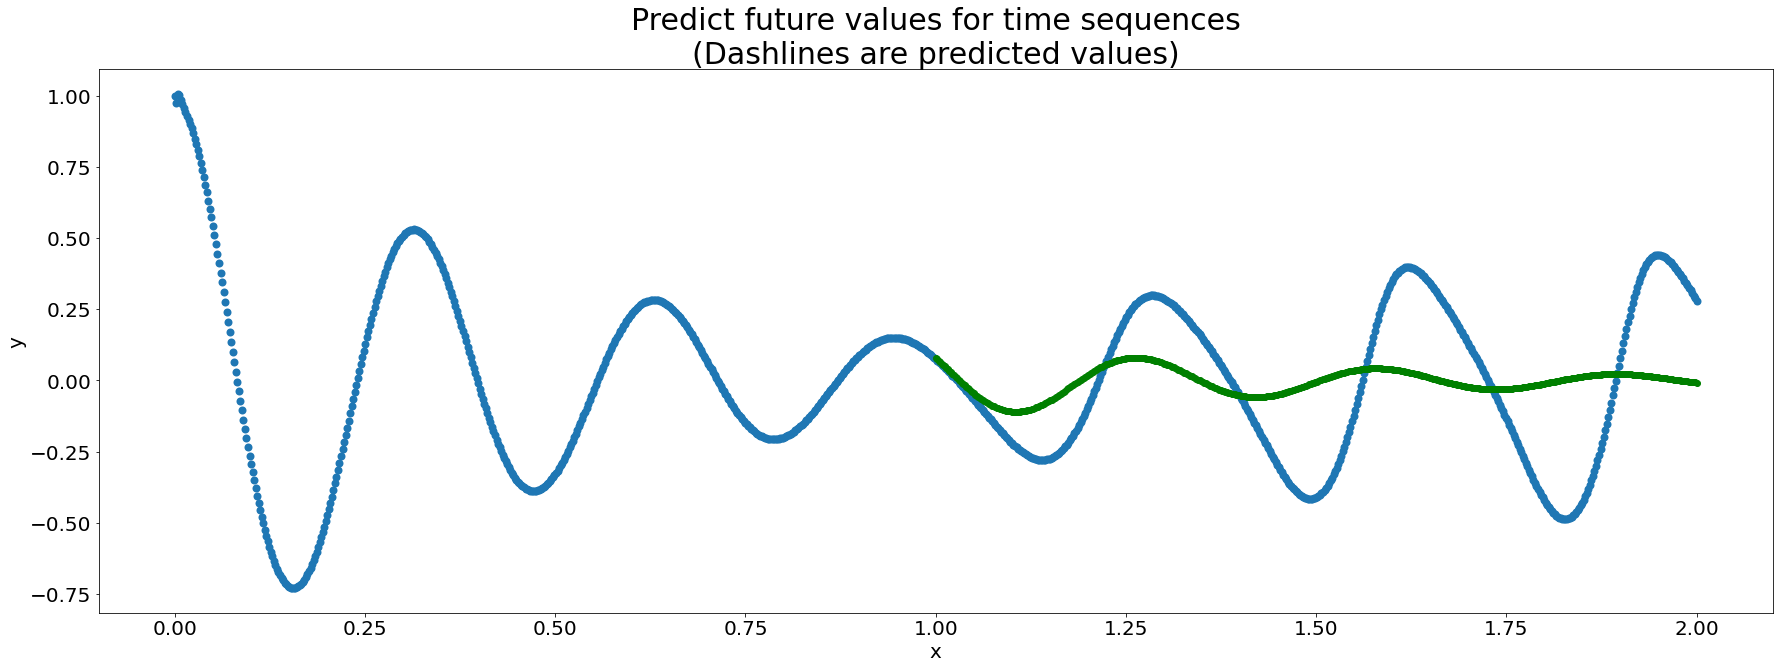

STEP:  8
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


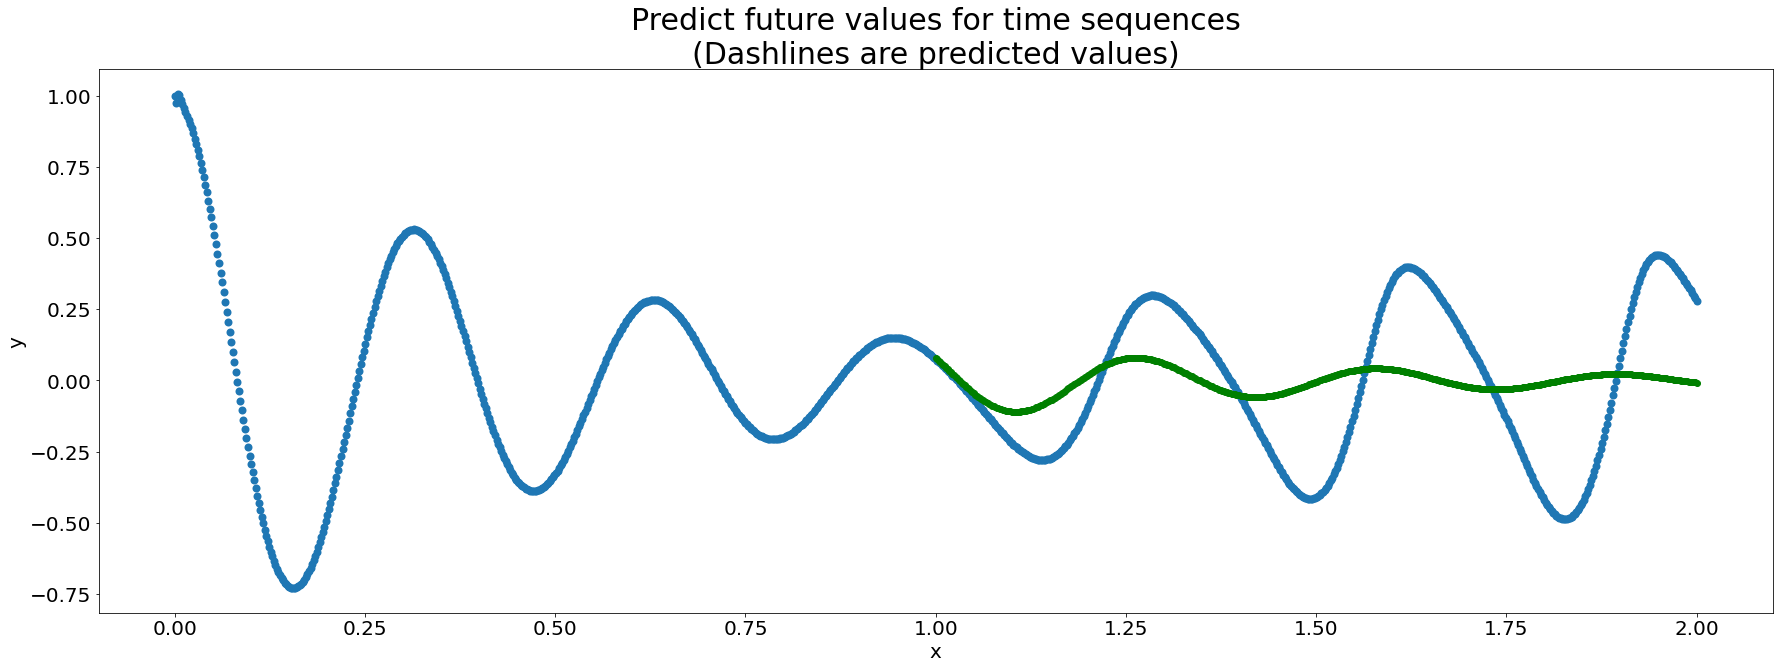

STEP:  9
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


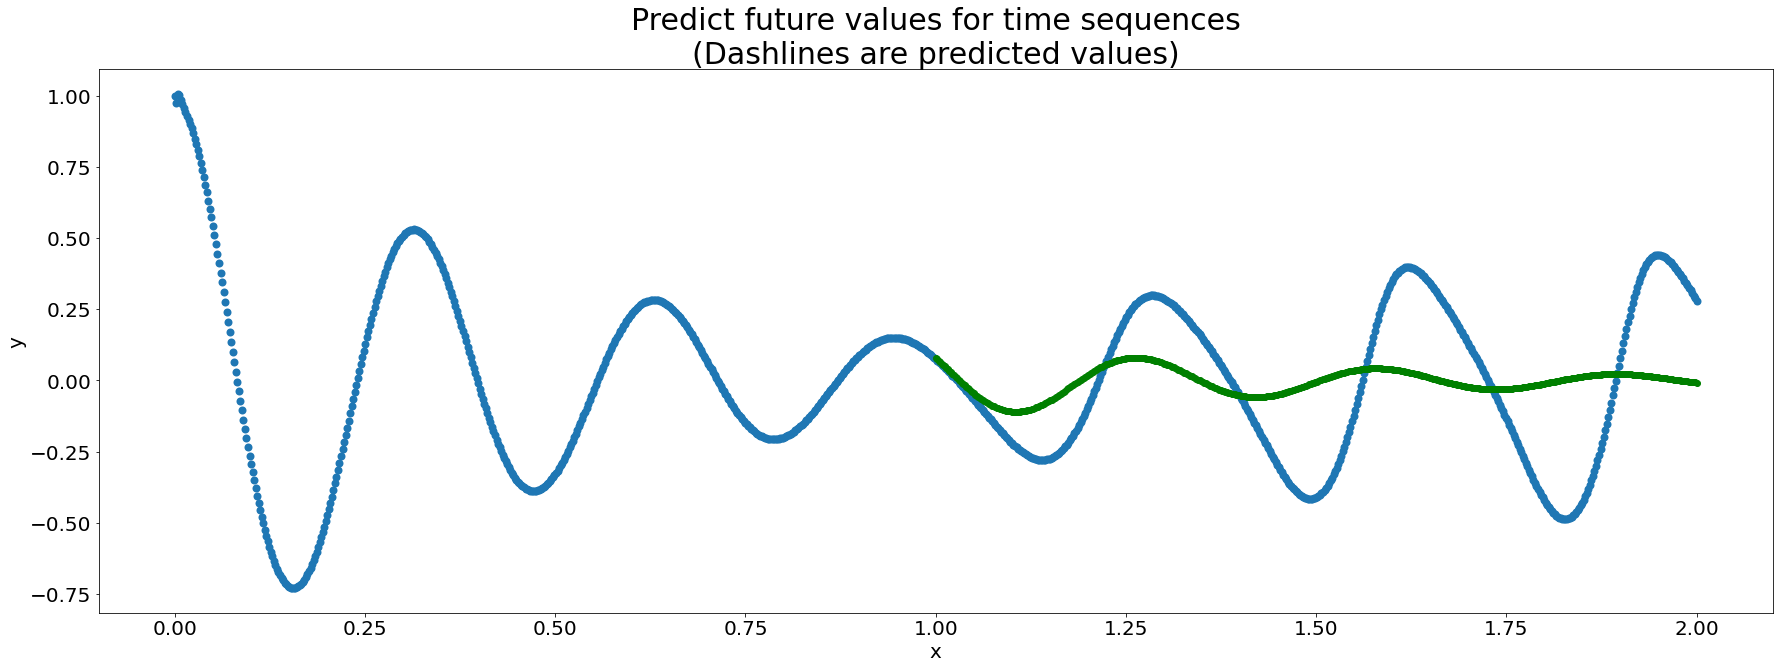

STEP:  10
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


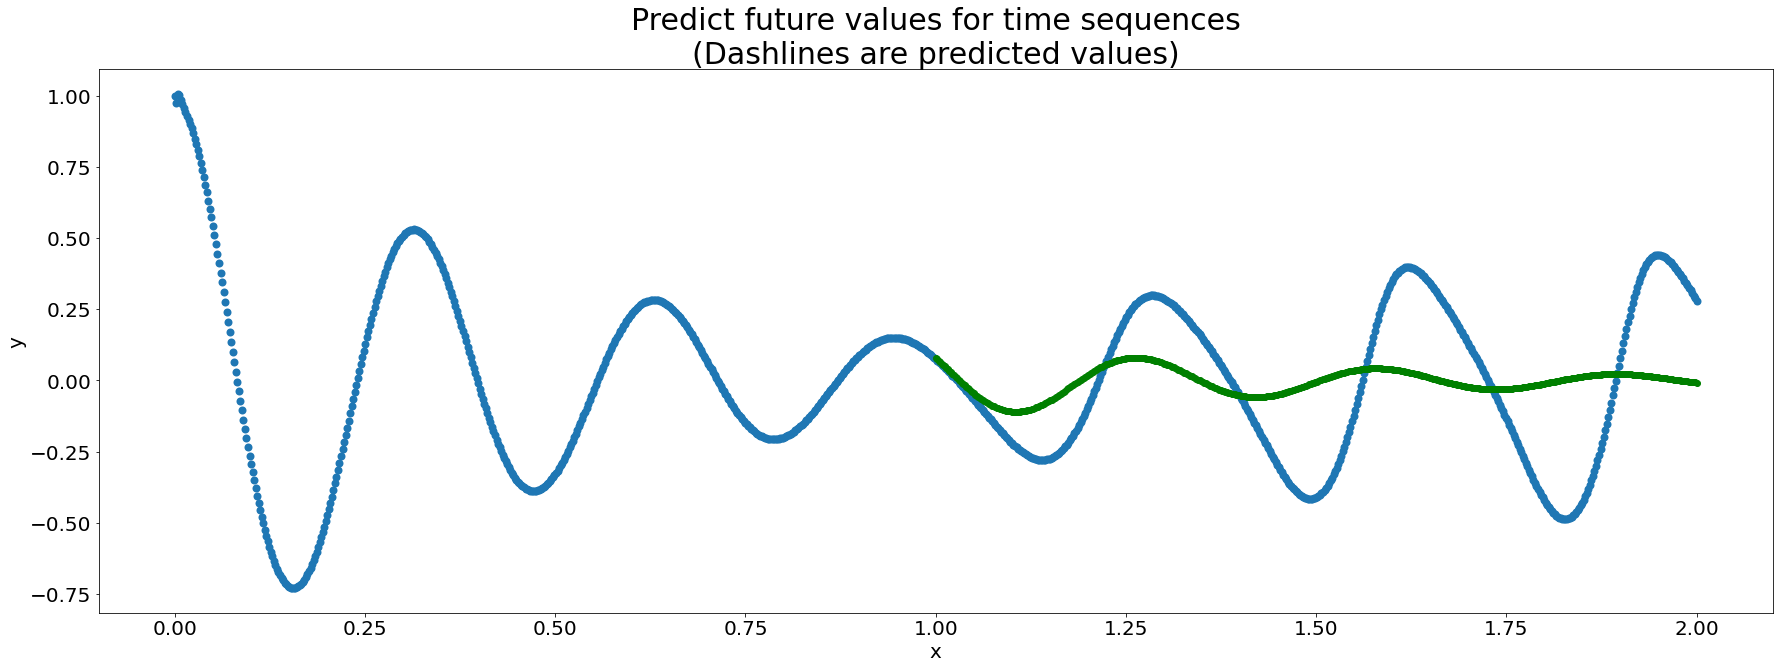

STEP:  11
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


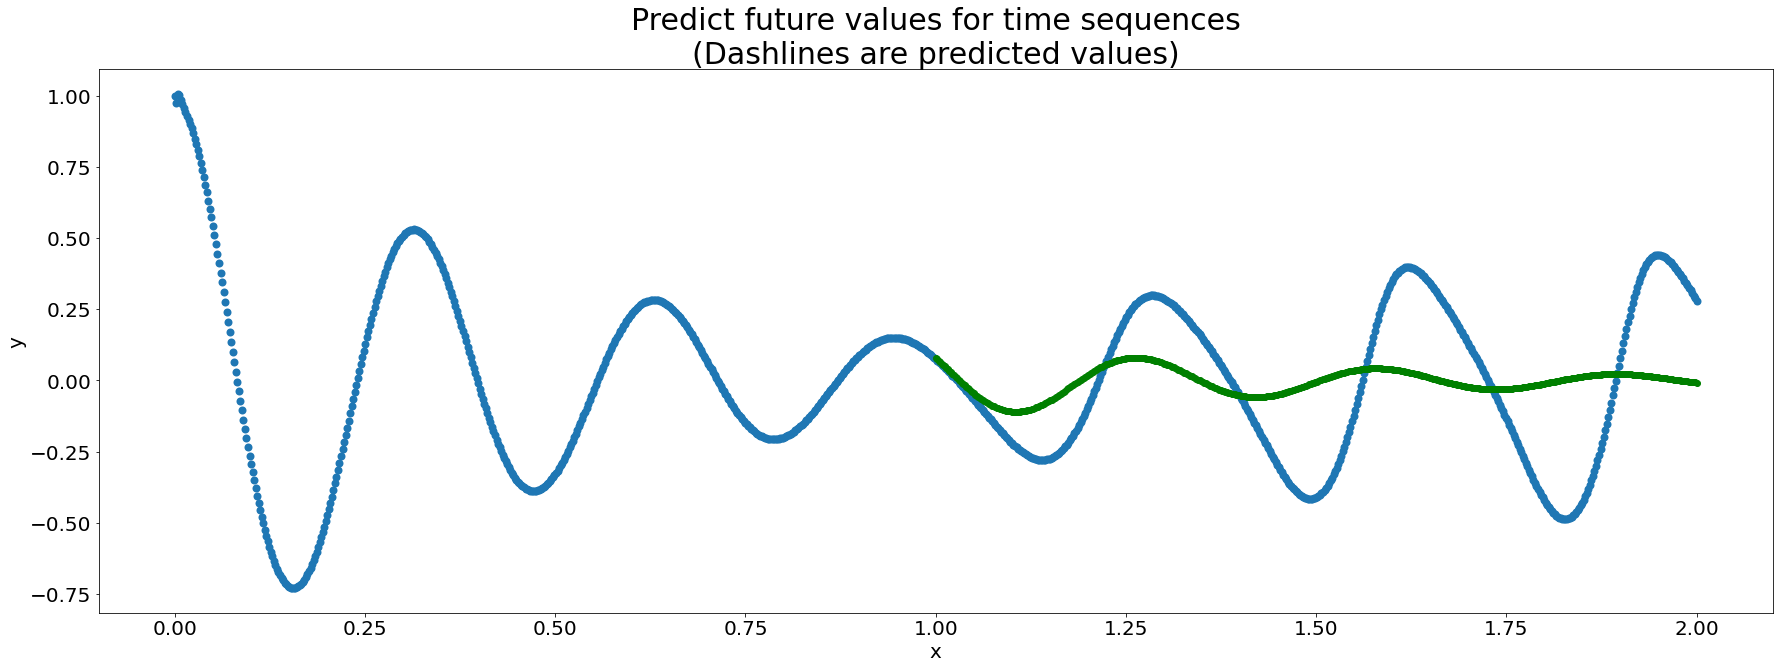

STEP:  12
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


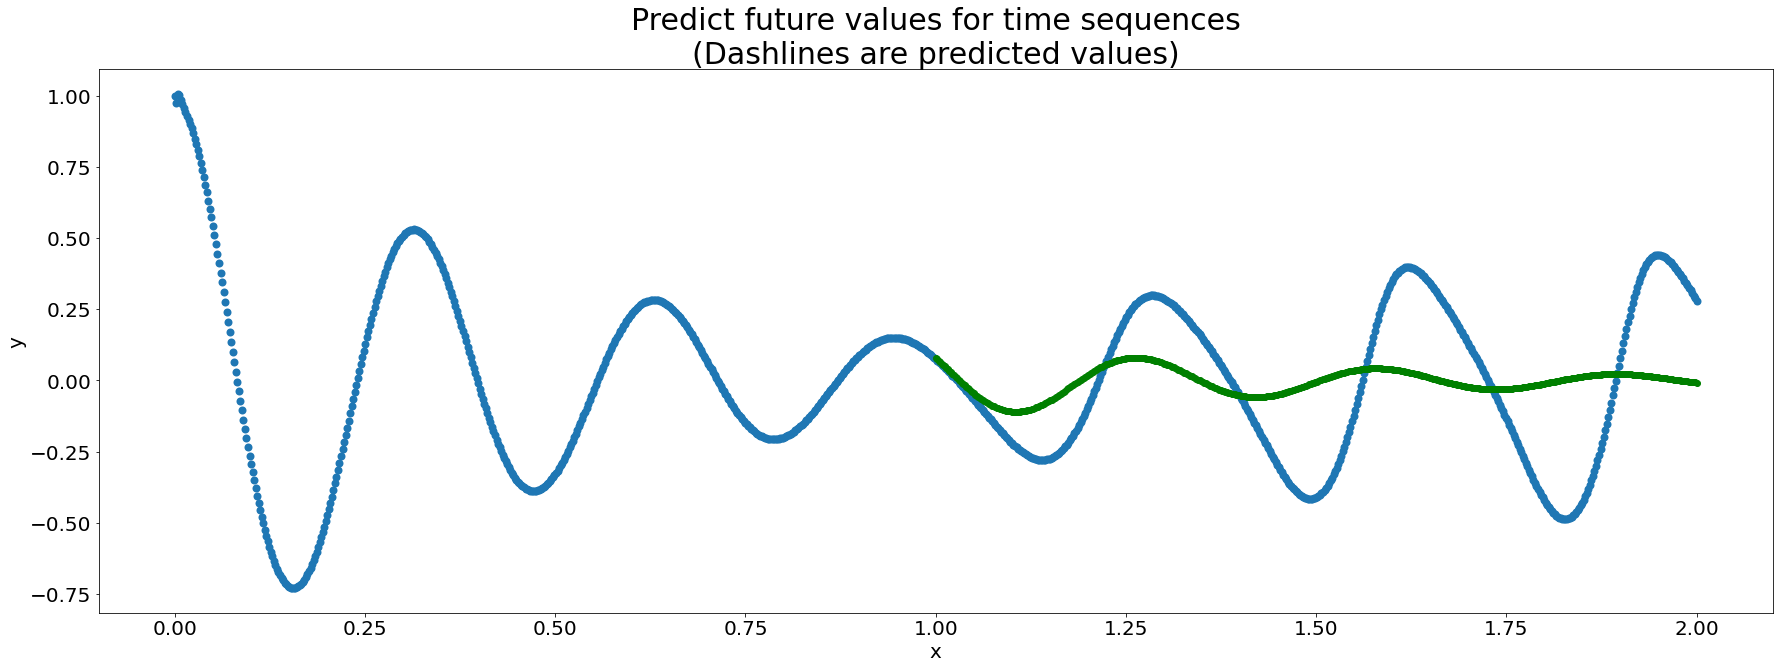

STEP:  13
loss: 1.3386142200033646e-05
Loss u: 3.637035e-06


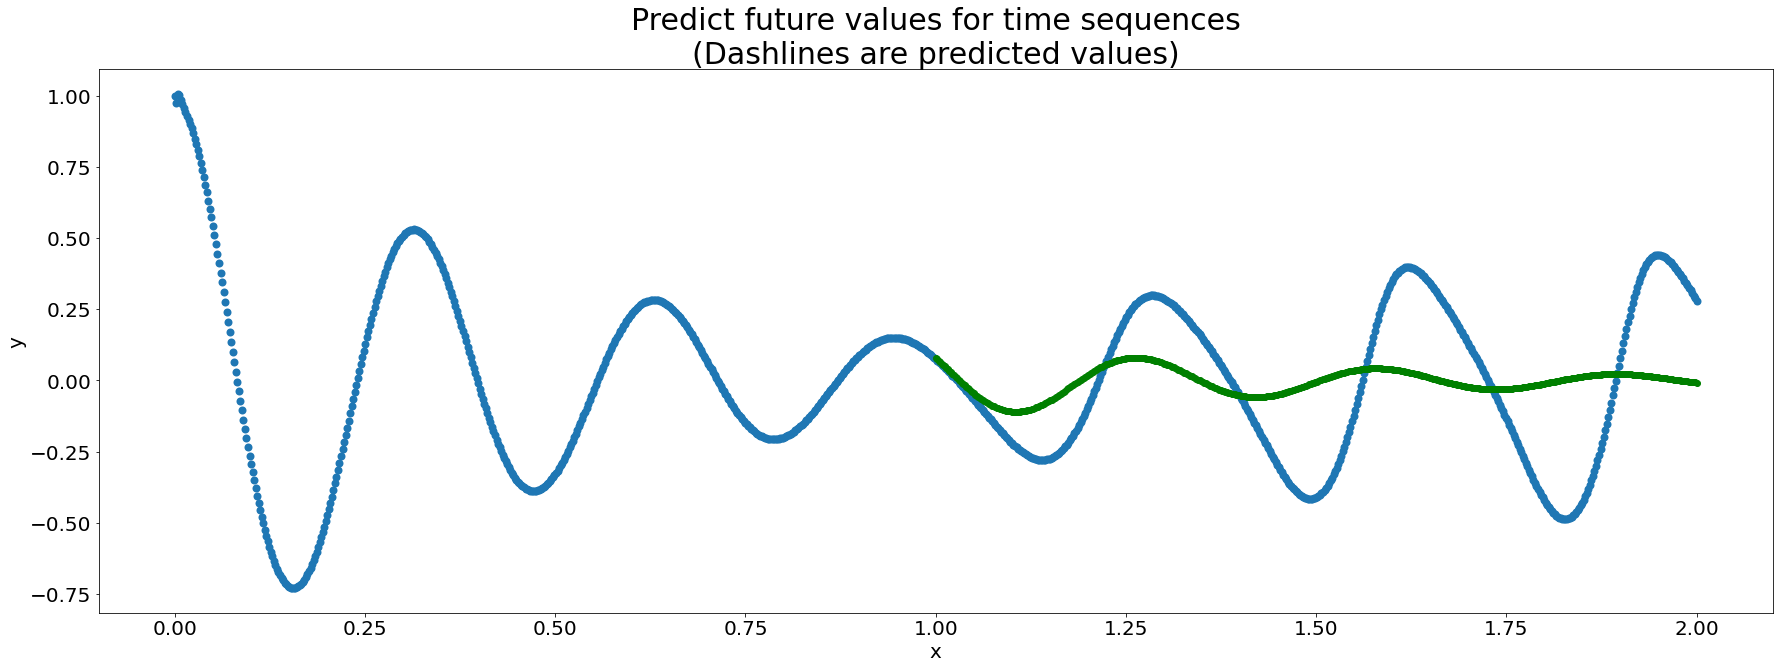

STEP:  14
loss: 1.3386142200033646e-05


KeyboardInterrupt: 

In [12]:

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
inpu = y[3:, :-1].to(device)
target =y[3:, 1:].to(device)
test_input = y[:3, :-1].to(device)
test_target = y[:3, 1:].to(device)
# build the model
seq = PhysicsInformedNN()


#begin to train

for i in range(500):
    print('STEP: ', i)

    def closure():
        seq.dnn.optimizer.zero_grad()
    
        physics , u_pred , u_t , u_tt = seq.net_f(inpu)
        
        c_i = u_pred[:,0]
        ones= torch.ones_like(c_i)
        loss_u_pred = torch.mean((ones - c_i)**2)
        #loss_u_t = torch.mean((u_t[:,0])**2)
        
        loss_u = torch.mean((target - u_pred)**2)
        # compute the "physics loss"
        loss_pde = (1e-9)*torch.mean(physics**2)
        
        loss = loss_u + loss_pde/2 + loss_u_pred #+ loss_u_t
    
        print('loss:', loss.item())
        loss.backward(retain_graph=True)
        return loss
    seq.dnn.optimizer.step(closure)



        
        
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq.net_u(test_input, future_preds=future)
        loss_u = torch.mean((test_target - pred[:, :-future])**2)
        print('Loss u: %e'%(loss_u.item()))
        y = pred.detach().cpu().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    d_t=len(y[0])
    plt.scatter(np.linspace(0,2,d_t), y[0], linewidth = 2.0)
    plt.scatter(x_test[1],y_test[1],color="g")
    #plt.savefig('plots_lstm/predict%d.jpg'%i)
    plt.show()
    plt.close()

In [13]:
physics , u_pred , u_t , u_tt = seq.net_f(inpu)

In [14]:
u_pred

tensor([[1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791],
        ...,
        [1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9751, 1.0061,  ..., 0.0884, 0.0838, 0.0791]],
       device='cuda:0', grad_fn=<CatBackward0>)